In [1]:
import lightning
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class COVIDXDataset(torch.utils.data.Dataset):
    def __init__(self, path, split, transform=None):
        self.path = path
        self.split = split
        self.transform = transform

        self.data = pd.read_csv(f"{self.path}/{self.split}.txt", sep=" ", header=None)
        self.data.columns = ['pid', 'filename', 'class', 'source']
        self.data = self.data.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filename = f"{self.path}/{self.split}/{row['filename']}"
        image = torchvision.io.read_image(filename, mode=torchvision.io.image.ImageReadMode.GRAY)
        image = image.float() / 255.0
        image = image.expand(3, -1, -1)
        label = (row["class"] == "positive") * 1
        if self.transform:
            image = self.transform(image)
        return image, label

class COVIDXDataModule(lightning.LightningDataModule):
    def __init__(self, path="data/raw/COVIDX-CXR4", transform=None, batch_size=32):
        super().__init__()
        self.path = path
        self.transform = transform
        self.batch_size = batch_size

    def setup(self):
        self.train_dataset = COVIDXDataset(self.path, 'train', transform=self.transform)
        self.val_dataset = COVIDXDataset(self.path, 'val', transform=self.transform)
        self.test_dataset = COVIDXDataset(self.path, 'test', transform=self.transform)
        return self

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size)

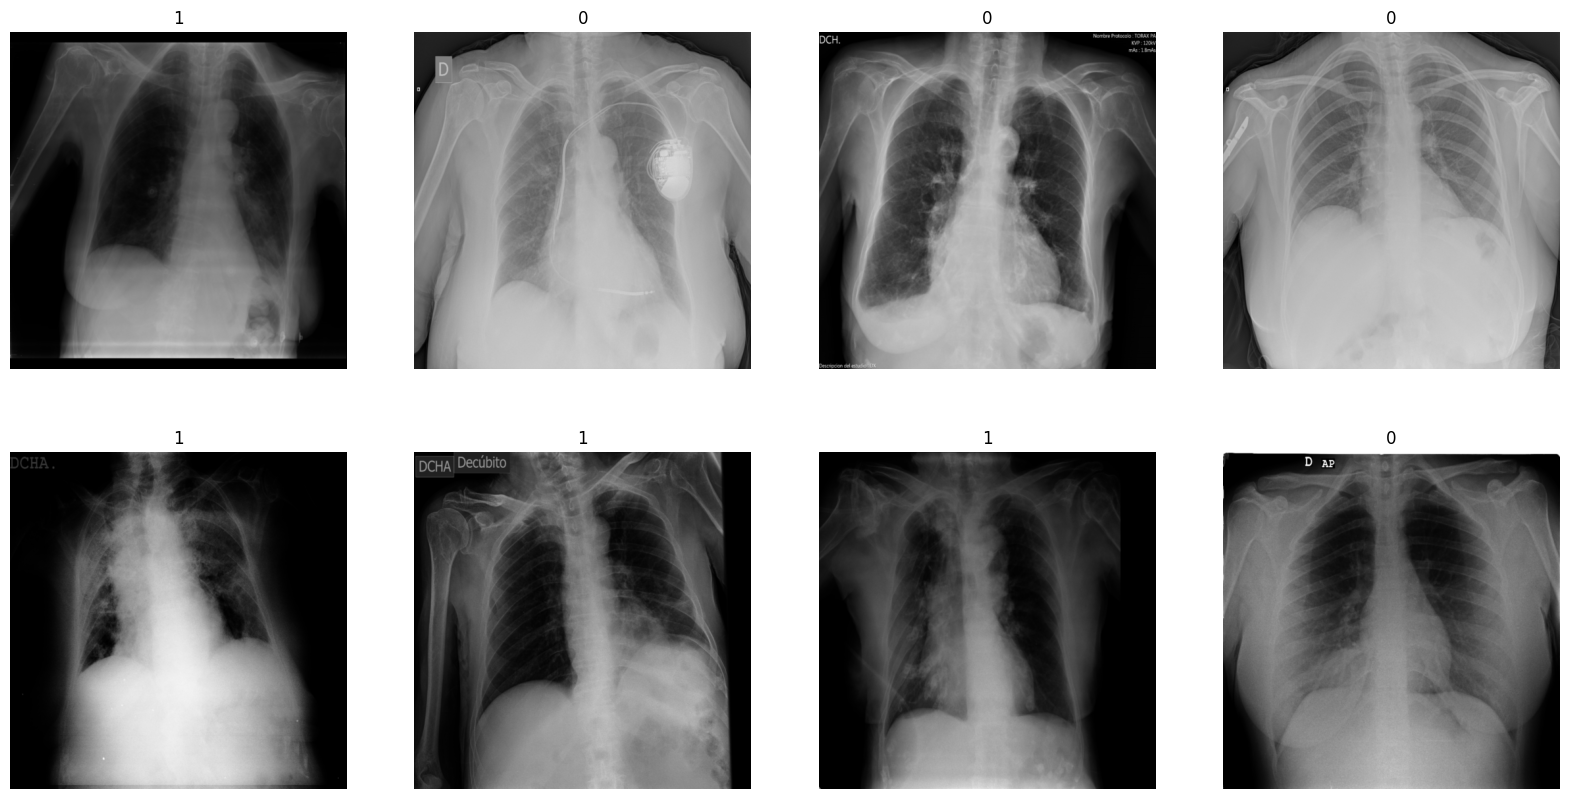

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((512, 512), antialias=True),
    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
])


data = COVIDXDataModule(path="../data/raw/COVIDX-CXR4", transform=transform, batch_size=8).setup()

for batch in data.test_dataloader():
    image, label = batch
    plt.figure(figsize=(20, 10))
    for i in range(image.shape[0]):
        plt.subplot(2, 4, i+1)
        plt.imshow(image[i].permute(1,2,0).clip(0,1), cmap='gray')
        plt.axis('off')
        plt.title(label[i].item())
    break

---


In [4]:
import os
import shutil
import numpy as np

class Process_BrainTumorMRI():
    def __init__(self) -> None:
        self.path_raw = '../data/raw/Brain-Tumor-MRI'
        self.path_processed = '../data/processed/Brain-Tumor-MRI'

    def _create_directory_structure(self):
        os.makedirs(f"{self.path_processed}/train/", exist_ok=True)
        os.makedirs(f"{self.path_processed}/val/", exist_ok=True)
        os.makedirs(f"{self.path_processed}/test/", exist_ok=True)

    def _get_folders(self):
        return os.listdir(self.path_raw)
    
    def _copy_files(self):
        self._create_directory_structure()
        for data_partition in self._get_folders():
            source_path = os.path.join(self.path_raw, data_partition)
            if data_partition == "Training":
                dest_path_train = os.path.join(self.path_processed, "train")
                dest_path_val = os.path.join(self.path_processed, "val")
                self._process_files(source_path, dest_path_train, dest_path_val=dest_path_val, is_training=True)
            elif data_partition == "Testing":
                dest_path = os.path.join(self.path_processed, "test")
                self._process_files(source_path, dest_path, is_training=False)
            else:
                continue  # Skip any unexpected folders

    def _process_files(self, source_path, dest_path_train, dest_path_val=None, is_training=True):
        for tumor_label in os.listdir(source_path):
            tumor_label_path = os.path.join(source_path, tumor_label)
            files = os.listdir(tumor_label_path)
            if is_training:
                np.random.seed(42)
                num_val_files = int(len(files) * 0.2)
                val_files = np.random.choice(files, num_val_files, replace=False)
            for file in files:
                new_file_name = f"{tumor_label}_{file}"
                file_source_path = os.path.join(tumor_label_path, file)
                if is_training and file in val_files:
                    file_dest_path = os.path.join(dest_path_val, new_file_name)
                else:
                    file_dest_path = os.path.join(dest_path_train, new_file_name)
                shutil.copy(file_source_path, file_dest_path)  # Changed from shutil.move to shutil.copy

    def _generate_labels_files(self):
        for dataset_type in ['train', 'val', 'test']:
            path = os.path.join(self.path_processed, dataset_type)
            with open(f'{self.path_processed}/{dataset_type}.txt', 'w') as labels_file:
                for filename in os.listdir(path):
                    if filename.endswith(".jpg"):  # Assuming we are working with jpg images
                        tumor_label = filename.split('_')[0]  # Extracting the tumor label from the filename
                        tumor_binary_label = 0 if tumor_label == 'no' else 1
                        labels_file.write(f"{filename},{tumor_label},{tumor_binary_label}\n")

    def process(self):
        self._copy_files()
        self._generate_labels_files()


In [5]:
braintumormri = Process_BrainTumorMRI()
braintumormri.process()